In [1]:
%matplotlib inline
import pandas as pd, matplotlib.pyplot as plt
import seaborn as sn, numpy as np
from mpl_toolkits.basemap import Basemap
from geopy.distance import vincenty
sn.set_context('notebook')

# Match ICPW trends sites (2006 and 2015)

## 1. Background

Back in 2006, analysis of the ICP Waters data identified some interesting trends. We would like to update the analysis to include data up to 2015, but site names and codes have changed in the meantime. The sites have already been selected for the 2015 analysis, but it is not known how these compare to those used in 2006. The aim here is to plot the 2006 sites against the 2015 sites to work out which ones are common between the two sets and which are not. Unfortunately, this is not as straightforward as simply matching the site codes, as there is no consistent set of site IDs between all countries and time periods.

## 2. Basic datasets

In an e-mail sent 19/05/2016 at 09:30, Tore sent a list of the 678 sites used in the 2006 analysis. This file is called *toc_data2.xls* and it includes latitude and longitude information for each location.

The sites used in the 2015 update are in the RESAII database, organized into projects with titles beginning *ICPW_TOCTRENDS_2015_XXXX*. Note that the two projects entitled *ICPW_TOCTRENDS_2015_SE_Excluded* and *ICPW_TOCTRENDS_2015_SE_River_Excluded* are **not** part of the analysis. 
 
Begin by extracting details for the 2015 sites from RESAII so we can compare them to the 2006 data provided by Tore. There  are 722 sites in total (see *Sites_2015.xlsx*), of which 14 have no location information:

|  Station_ID |      Station_Name      |
|:-----------:|:----------------------:|
| UK_26       | Loch Coire Fionnaraich |
| X15:1C1-106 | SUCKER                 |
| X15:1C3-075 | SOUTH - MARLBORO       |
| X15:1C1-104 | LITTLE ROCK            |
| X15:1C1-108 | BIG MUDDY              |
| X15:1C2-073 | OSMORE                 |
| X15:1C2-071 | PIGEON                 |
| X15:1C2-074 | WHEELER                |
| X15:1C3-064 | KETTLE                 |
| X15:1C1-094 | LITTLE - WINHALL       |
| X15:020059O | BIG HOPE POND          |
| X15:1C3-076 | FORESTER               |
| X15:1C2-075 | COW MOUNTAIN           |
| X15:1C1-111 | HOLLAND                |

It will therefore not be possible to match these based on spatial data, but I'll return to them later.

## 3. Site maps

Let's begin by mapping the sites. The easiest way to do this is using ArcGIS, but the NIVA GIS licence seems to be "ESRI Basic", which lacks the functionality I'll need later. For now, I'll do everything in code instead.

**Note:** Check with IT-Vakt to see whether we have access to any "ESRI Advanced" licences, which would be useful in the future.

In [2]:
# Read data
old_xls = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
           r'\Nature_2006_2015_Update\Match_Sites\toc_data2.xls')
new_xls = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
           r'\Nature_2006_2015_Update\Match_Sites\raw_sites_2015.xlsx')

old_df = pd.read_excel(old_xls, sheetname='statt')
new_df = pd.read_excel(new_xls, sheetname='DATA')

It looks as though both datasets have a unique **Station_ID** column, which I can use to identify the sites for my analysis here. Let's check that these IDs are unique *within each file* and then extract just the latitude and longitude data.

In [3]:
# Check for duplicate IDs
print 'Number of duplicated site IDs:'
print 'Old:', old_df['STATION_ID'].duplicated().sum()
print 'New:', new_df['Station ID'].duplicated().sum()

# Extract spatial info
old_loc = old_df[['STATION_ID', 'LATITUDE', 'LONGITUDE']]
new_loc = new_df[['Station ID', 'Latitude', 'Longitude']]

# Drop the 14 rows with no spatial data from the 2015 dataset
new_loc = new_loc.dropna(how='any')

# Tidy up column headings
cols = ['stn_id', 'lat', 'long']
old_loc.columns = cols
new_loc.columns = cols

Number of duplicated site IDs:
Old: 0
New: 0


Good. Now let's map the points. First of all, side-by-side.

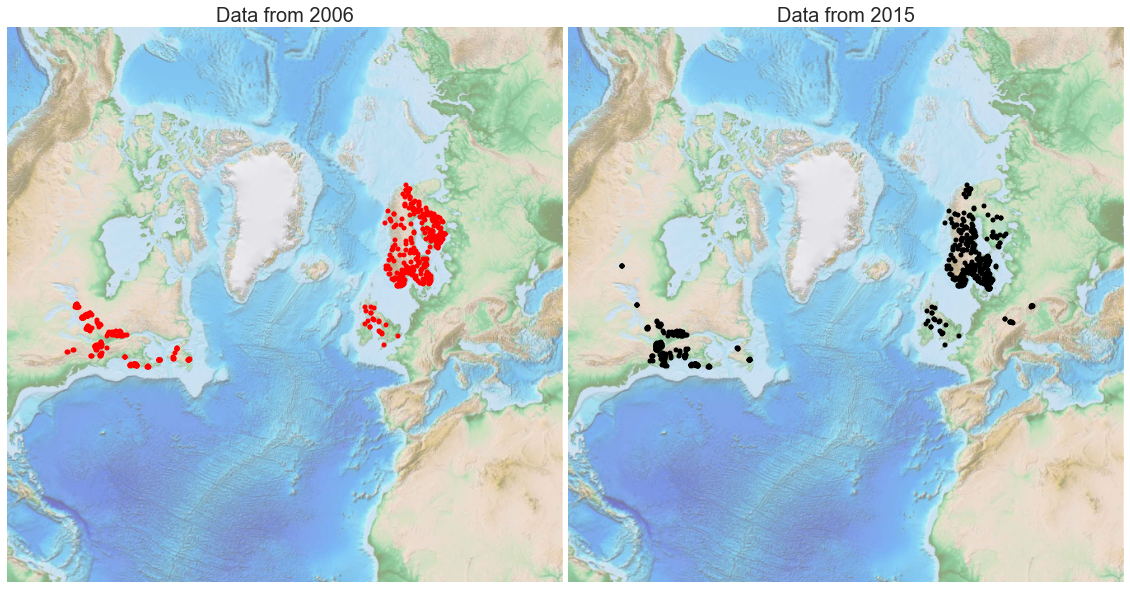

In [4]:
fig = plt.figure(figsize=(20, 15))

# Old data
ax = fig.add_subplot(121)
ax.set_title('Data from 2006', fontsize=20)

# Use a Lambert Conformal Conic projection
m = Basemap(projection='lcc', resolution=None,
            lon_0=-30, lat_0=60, lat_1=45, lat_2=55,
            width=1E7, height=1E7)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(old_loc['long'].values, old_loc['lat'].values)
ax.plot(x, y, 'or', markersize=5)

# New data
ax = fig.add_subplot(122)
ax.set_title('Data from 2015', fontsize=20)

# Use a Lambert Conformal Conic projection
m = Basemap(projection='lcc', resolution=None,
            lon_0=-30, lat_0=60, lat_1=45, lat_2=55,
            width=1E7, height=1E7)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(new_loc['long'].values, new_loc['lat'].values)
ax.plot(x, y, 'ok', markersize=5)

plt.subplots_adjust(wspace=0.01)

We can also overlay the two sets of points, although they then obscure one another. This can be improved slightly by making each set **partially transparent**.

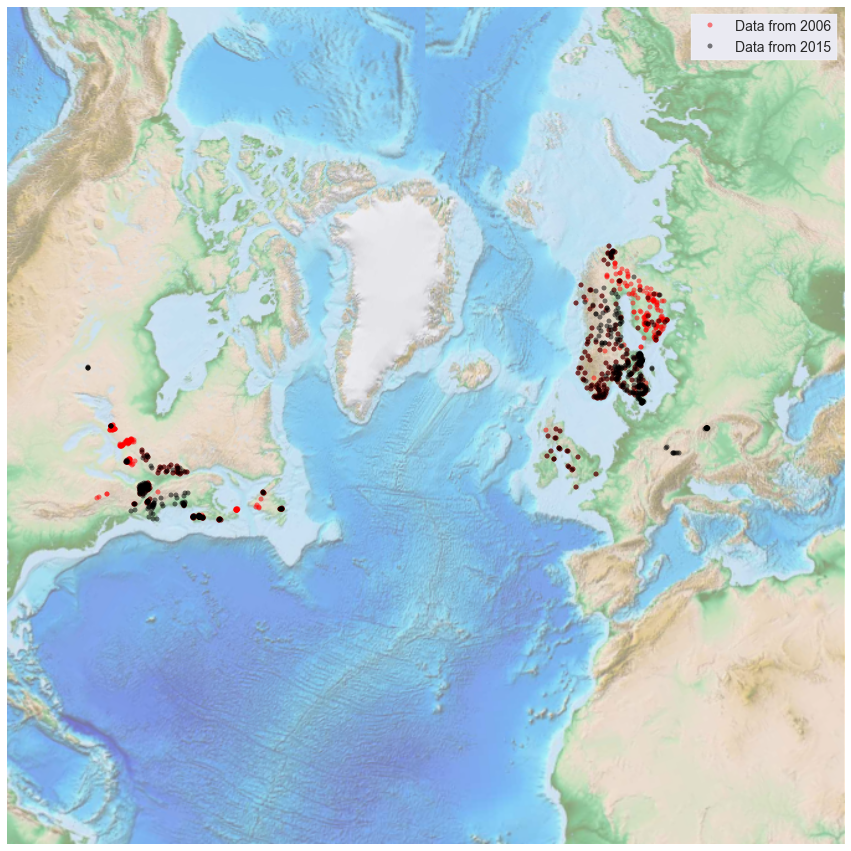

In [5]:
fig = plt.figure(figsize=(15, 15))

# Use a Lambert Conformal Conic projection
m = Basemap(projection='lcc', resolution=None,
            lon_0=-30, lat_0=60, lat_1=45, lat_2=55,
            width=1E7, height=1E7)
m.etopo(scale=0.5, alpha=0.5)  
    
# Map (long, lat) to (x, y) for plotting
# Old
x_o, y_o = m(old_loc['long'].values, old_loc['lat'].values)
plt.plot(x_o, y_o, 'or', markersize=5, label='Data from 2006', alpha=0.5)

# New
x_n, y_n = m(new_loc['long'].values, new_loc['lat'].values)
plt.plot(x_n, y_n, 'ok', markersize=5, label='Data from 2015', alpha=0.5)

plt.legend(loc='best', frameon=True, fontsize=14)

It's pretty clear from these maps that the 2015 analysis has removed a lot of points from Finland and added some new ones from Eastern Europe. The distribution of stations in Canada and the US has also changed. This is consistent with John Stoddard's conclusions (see e-mail forwarded from Heleen 19/05/2016 at 13:06), but does not provide much new information. Based on these maps alone it is not easy to work out which sites match between periods and which don't.

## 4. Data exploration

Next step, let's calculate a distance grid showing the separation between each of the sites. This will require geodesic calculations on the WGS84 elipsoid using the **[Vincenty formula](https://en.wikipedia.org/wiki/Vincenty%27s_formulae)** (implemented by [geopy](https://pypi.python.org/pypi/geopy)). This will create a large distance matrix of consisting of $678 x 708 = 480024$ values.

In [6]:
# Dict to store data
data_dict = {'old_id':[],
             'new_id':[],
             'dist_km':[]}

# Loop over sites
for old_site in old_loc.iterrows():
    # First site co-ords
    old_id, old_lat, old_long = old_site[1]
    
    # Second site co-ords
    for new_site in new_loc.iterrows():
        new_id, new_lat, new_long = new_site[1]
        
        # Get geodesic distance
        dist = vincenty((old_lat, old_long), (new_lat, new_long)).meters / 1000.
        
        # Append results
        data_dict['old_id'].append(old_id)
        data_dict['new_id'].append(new_id)
        data_dict['dist_km'].append(dist)

# Build df
dist_df = pd.DataFrame(data_dict)
dist_df = dist_df[['old_id', 'new_id', 'dist_km']]

print len(dist_df)

dist_df.head(10)

480024


,old_id,new_id,dist_km
0,101.0,37284.0,5221.001844
1,101.0,37320.0,5115.375745
2,101.0,37300.0,5156.245982
3,101.0,37311.0,5155.741152
4,101.0,37301.0,5144.920094
5,101.0,37283.0,5224.466877
6,101.0,37318.0,5123.215731
7,101.0,37313.0,5160.398876
8,101.0,37298.0,5144.961108
9,101.0,37327.0,4947.924009


How can we use this information? To start off, let's see how many of the sites share the same ID?

In [7]:
df = dist_df.query('old_id == new_id')
print len (df)

98


And, of these, how many are within 1 km of each other?

In [8]:
df = dist_df.query('(old_id == new_id) and (dist_km <= 1)')
print len (df)

90


This result suggests that we **cannot use the site IDs** to connect the sites, *even in cases where the site IDs match*. Either the latitude and longitude co-ordinates have been rounded very coarsely in one or both of the datasets, or the same site IDs have been used ***for different sites*** in the two analyses. This is going to make matching them up difficult.

It might be interesting to consider how the "*number of sites closer than a particular distance*" changes as the distance varies. This might provide clues as to the **average accuracy** of the geographic co-ordinates. The histogram of distances could also be useful.

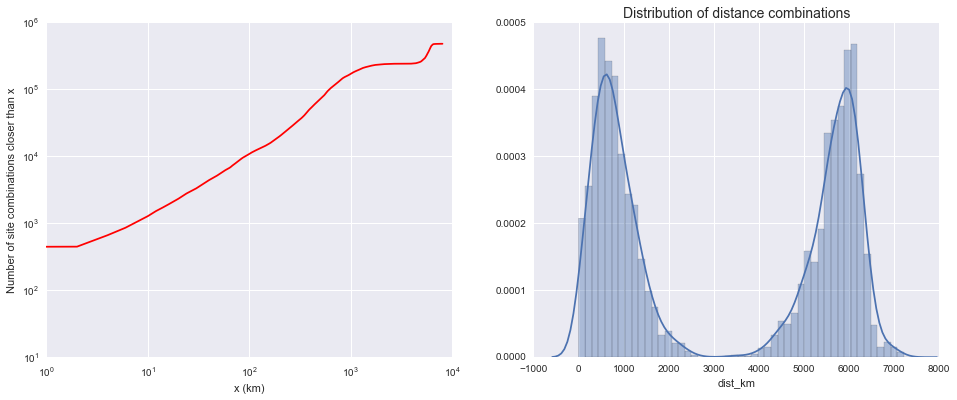

In [9]:
# List to store counts
cnts = []
dists = np.arange(0, 8000, 2)
for dist in dists:
    df = dist_df.query('dist_km <= @dist')
    cnts.append(len(df))
    
# Plot counts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axes[0].plot(dists, cnts, 'r')
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_ylabel('Number of site combinations closer than x')
axes[0].set_xlabel('x (km)')

# Plot hist
sn.distplot(dist_df['dist_km'], ax=axes[1], hist=True, kde=True)
axes[1].set_title('Distribution of distance combinations', fontsize=14)

The histogram is **strongly bimodal** because of the Atlantic, which is nice to see, but not especially helpful. The horizontal line and the kink in the curve at the start of the left-hand plot is interesting though - it implies the number of sites closer than a few kilometres is fairly constant and does not follow the pattern observed at larger distances. This could be due to spatial autocorrelation in the way countries choose their monitoring sites, but it could also reflect the fundamental accuracy to which the latitude and longitude co-ordinates have been specified. This could be useful, so let's take a closer look at the portion of the curve between 0 and 10 kilometres.

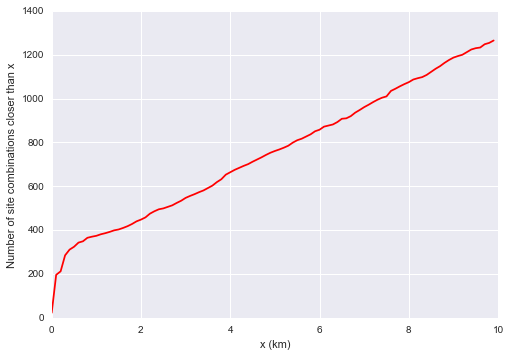

In [10]:
# List to store counts
cnts = []
dists = np.arange(0, 10, 0.1)
for dist in dists:
    df = dist_df.query('dist_km <= @dist')
    cnts.append(len(df))
    
# Plot
plt.plot(dists, cnts, 'r')
plt.ylabel('Number of site combinations closer than x')
plt.xlabel('x (km)')

Looking at this plot, I'd say there's an obvious kink at around $x = 1 \; km$. This change in trend could mark the cutoff between coincident sites that have been reported with different co-ordinates and genuinely separate stations. 

How many stations are closer than this 1 km cutoff?

In [11]:
df = dist_df.query('dist_km <= 1')
print len (df)

374


So, if the above assumptions are about right, we're probably looking to identify around 300 to 400 sites that are common between the two datasets.

Another way to visualise the distances is using a **heatmap**. First, let's get rid of any values with a separation of more than 1 km, as based on the plots above these sites should be distinct from one another.

In [12]:
df = dist_df.query('dist_km <= 1')
df = df.sort_values(by=['old_id', 'new_id'])
df = df.pivot(index='old_id', columns='new_id', values='dist_km')

print df.shape

(357, 352)


The matrix is almost square. This is promising as we would expect a square matrix once we have successfully identified paired sites between the two analyses. $357 x 352$ is a large grid to visualise, though, so to begin with let's just plot the first 75 rows and columns to get an idea of what the full thing might look like.

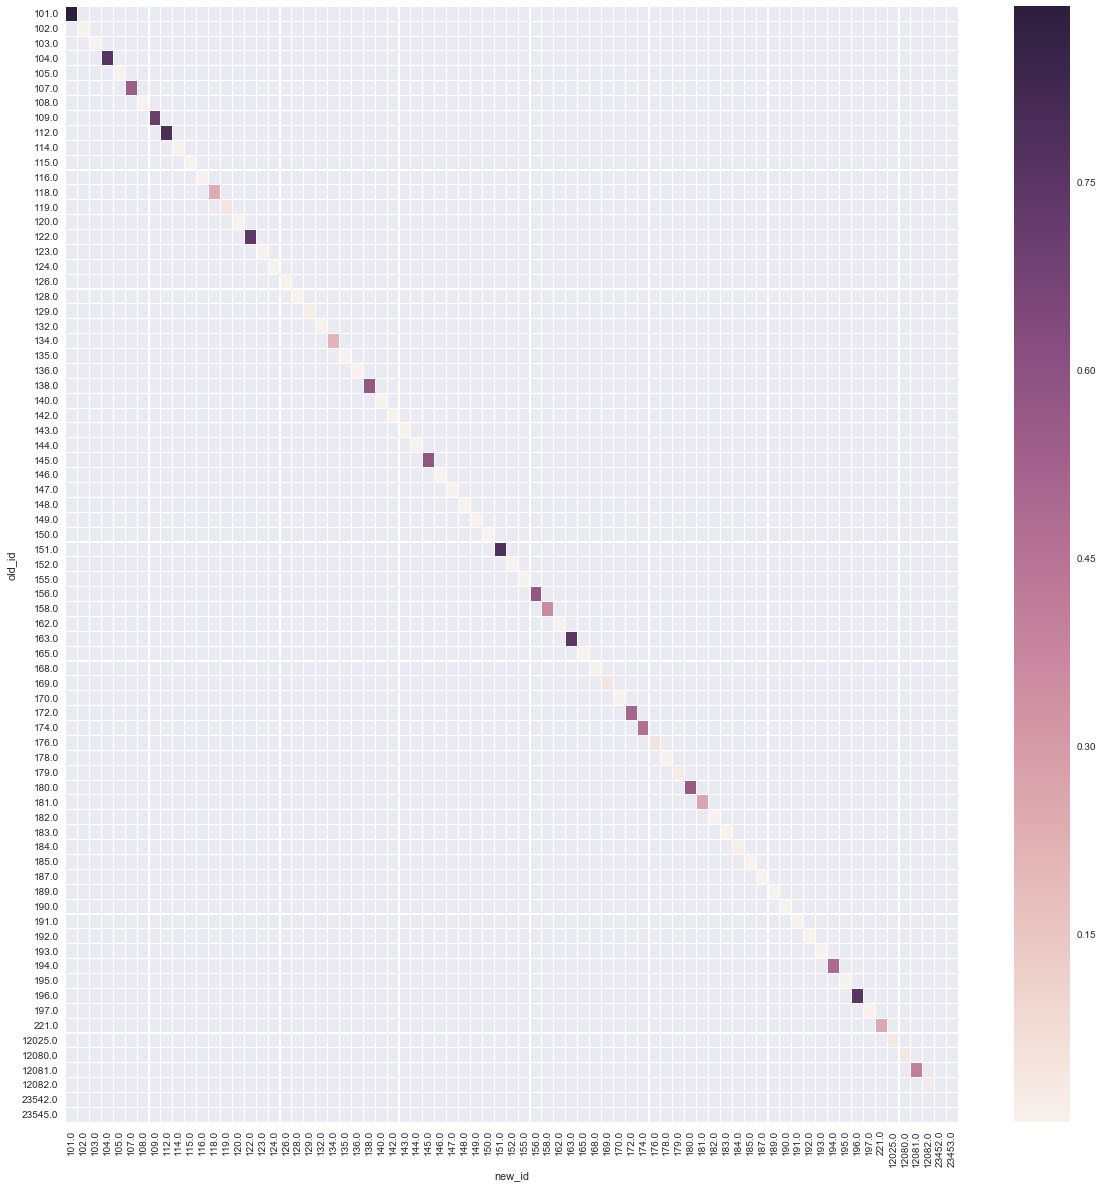

In [13]:
df2 = df.iloc[:75, :75]

fig = plt.figure(figsize=(20, 20))
sn.heatmap(df2, linewidths=0.1)

The site IDs in this matrix were sorted before plotting, so what we're seeing here are the first 75 of the 90 sites where the old ID matches the new ID and the separation distance is less than or equal to 1 km. These sites can be matched simply by linking the site IDs, but note we **can't do this everywhere**.

Let's plot to full matrix to see if the patterns are helpful.

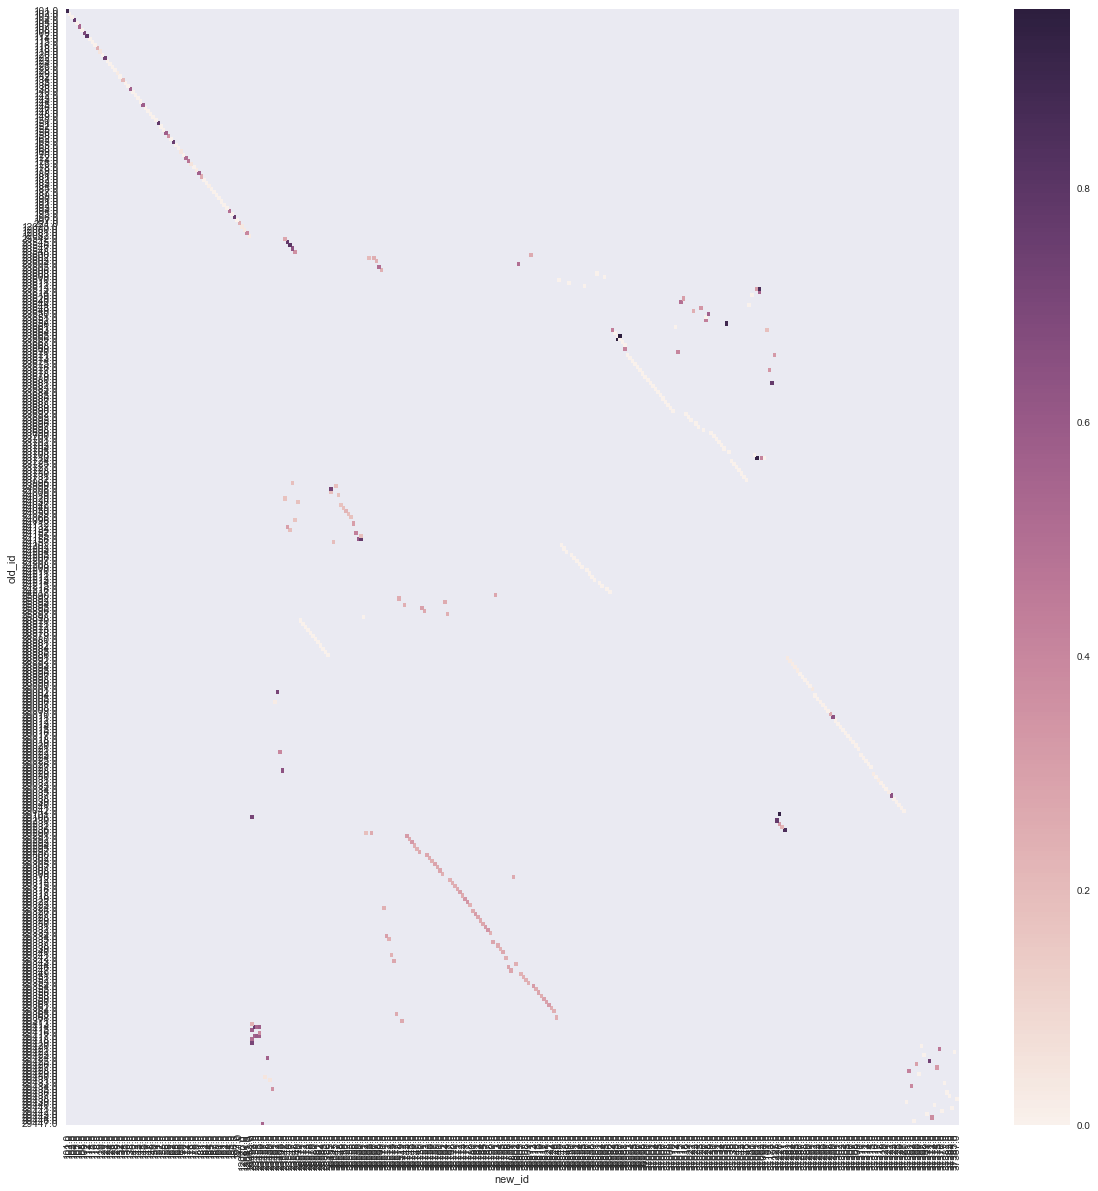

In [14]:
fig = plt.figure(figsize=(20, 20))
sn.heatmap(df)

It's obvious from this that not all the close sites lie along the diagonal of the matrix. It also seems as though in some cases there are multiple candidate matches based on the distance metric alone. Overall, this will make it difficult to match the sites, as it seems we can't rely on site IDs, codes, names or geographic co-ordinates!

Let's return to the sites closer than 1 km.

In [15]:
df = dist_df.query('dist_km <= 1')
print len (df)

374


And join-in the station details to get as much information as possible.

In [16]:
# Cols to use in old data
old_cols = ['STATION_ID', 'STATION_NAME', 'STATION_CODE']

# Cols to use in new data
new_cols = ['Station ID', 'Station name', 'Station Code']

# Join
df = pd.merge(df, old_df[old_cols], how='left', left_on='old_id', right_on='STATION_ID')
df = pd.merge(df, new_df[new_cols], how='left', left_on='new_id', right_on='Station ID')

# Rename cols and reorder
del df['old_id'], df['new_id']
df.columns = ['sep_km', 'old_id', 'old_name', 'old_code', 'new_id', 'new_name', 'new_code']
df = df[['old_id', 'new_id', 'old_name', 'new_name', 'old_code',  'new_code', 'sep_km']]

# Convert km to metres
df['sep_m'] = df['sep_km'] * 1000.
del df['sep_km']

df.head(10)

,old_id,new_id,old_name,new_name,old_code,new_code,sep_m
0,101,101,LANGVATN,Langvann,301-605,301-605,890.300762
1,102,102,Store Lyseren,Store Lyseren,221-605,221-605,2.309932
2,103,103,SANDVATN,Sandvatn,914-501,914-501,1.362669
3,104,104,RAVNSJØEN,Ravnsjøen,137-501,137-501,754.759867
4,105,105,HOLVATN,Holvatn,221-607,221-607,1.931597
5,108,108,"Langtjern, utløp","Langtjern, utløp",LAE01,LAE01,1.532793
6,109,109,HOMESTADVATN,Homestadvatnet,1021-14,1021-14,699.292093
7,112,112,GLYPSTADVATN,Glypstadvatnet,1101-43,1101-43,799.206054
8,114,114,SVARTTJERN,Svartetjernet,SVART01,SVART01,1.715356
9,115,115,BRÅRVATN,BrÃ¥rvatn,831-501,831-501,1.324933


It's clear there will be some issues here if we attempt to match based on station names (e.g. LANGVATN versus Langvann). Matching will also be made more difficult due to some problems encoding special characters in the RESAII database. The *ID* and *Code* columns could be useful though. Let's see how many of them match between the two datasets.

In [17]:
print len(df.query('old_code == new_code'))
print len(df.query('old_id == new_id'))

90
90


This indicates that the *ID* and *Code* columns contain essentially the same information. However note that, above, we identified 98 sites where `old_id == new_id`. This means there are **eight sites** with the same ID and station code, but where the latitude and longitude co-ordinates are more than 1 km apart. Let's find them.

In [18]:
df2 = dist_df.query('(old_id == new_id) and (dist_km >= 1)')
df2

,old_id,new_id,dist_km
5168,110.0,110.0,26.579281
10080,121.0,121.0,1.466537
12245,125.0,125.0,2.385019
19308,141.0,141.0,1.107000
29247,161.0,161.0,1.241807
32029,166.0,166.0,1.181972
34220,171.0,171.0,2.104242
34895,173.0,173.0,1.155762


Seven of these eight sites are actually pretty close together (within a few kilometres), and I'm willing to bet these differences are due to inaccuracies in the geographic co-ordinates. **Site ID 110** is substantially different, though.

Let's add some more details to see whether these eight site pairs are really the same.

In [19]:
# Join
df2 = pd.merge(df2, old_df[old_cols], how='left', left_on='old_id', right_on='STATION_ID')
df2 = pd.merge(df2, new_df[new_cols], how='left', left_on='new_id', right_on='Station ID')

# Rename cols and reorder
del df2['old_id'], df2['new_id']
df2.columns = ['sep_km', 'old_id', 'old_name', 'old_code', 'new_id', 'new_name', 'new_code']
df2 = df2[['old_id', 'new_id', 'old_name', 'new_name', 'old_code',  'new_code', 'sep_km']]

# Convert km to metres
df2['sep_m'] = df2['sep_km'] * 1000.
del df2['sep_km']

df2

,old_id,new_id,old_name,new_name,old_code,new_code,sep_m
0,110,110,Tennvatn,Tennvatn,1845-601,1845-601,26579.281065
1,121,121,Skaidejavri,Skaidejavri,2030-503,2030-503,1466.537141
2,125,125,St.Valvatnet,St.Valvatnet,2030-607,2030-607,2385.018945
3,141,141,Heddersvatnet,Heddersvatnet,827-601,827-601,1107.000305
4,161,161,MYKLEVATN,Myklevatn,940-502,940-502,1241.806967
5,166,166,KLEIVSETVATN,Kleivsetvannet,1018-4,1018-4,1181.971564
6,171,171,Kjemåvatn,Kjemåvatnet,1840-601,1840-601,2104.241613
7,173,173,Grovlivatnet,Grovlivatnet,1630-601,1630-601,1155.761931


It looks as though all eight sites are genuine matches between the two datasets, but the geographic co-ordinates have significant errors. The location error for **Tennvatn** (in Norway) is especially large.

So, matching based upon the *ID* or *Code* columns only returns 90 sites, which doesn't get us very far. However, Tore's e-mail mentioned adding "X15:" to some of the station codes in the 2015 analysis in order to avoid violating constraints in the RESAII database. Perhaps if we strip off these additions we can match up a few more of the sites?

In [20]:
def strip_x15(x):
    """ Remove "X15:" from columns in df.
    """
    if x[:4] == 'X15:':
        return x[4:]
    else:
        return x

# Apply to df
df['new_code2'] = df['new_code'].apply(strip_x15)

print len(df.query('old_code == new_code2'))

200


This gives a few more matches, which is an improvement.

However, if I repeat the analysis above using **all** distances, rather than just those less than 1 km, I get **213 matches** instead of 200. This implies there are **thirteen** sites with the same original site code, but significantly different locations. It's worth identifying these sites now for checking later.

In [21]:
# Join
df2 = pd.merge(dist_df, old_df[old_cols], how='left', left_on='old_id', right_on='STATION_ID')
df2 = pd.merge(df2, new_df[new_cols], how='left', left_on='new_id', right_on='Station ID')

# Rename cols and reorder
del df2['old_id'], df2['new_id']
df2.columns = ['sep_km', 'old_id', 'old_name', 'old_code', 'new_id', 'new_name', 'new_code']
df2 = df2[['old_id', 'new_id', 'old_name', 'new_name', 'old_code',  'new_code', 'sep_km']]

# Convert km to metres
df2['sep_m'] = df2['sep_km'] * 1000.
del df2['sep_km']

# Strip "X15:"
df2['new_code2'] = df2['new_code'].apply(strip_x15)

df2.query('(old_code == new_code2) and (sep_m > 1000)')

,old_id,new_id,old_name,new_name,old_code,new_code,sep_m,new_code2
5168,110,110,Tennvatn,Tennvatn,1845-601,1845-601,26579.281065,1845-601
10080,121,121,Skaidejavri,Skaidejavri,2030-503,2030-503,1466.537141,2030-503
12245,125,125,St.Valvatnet,St.Valvatnet,2030-607,2030-607,2385.018945,2030-607
19308,141,141,Heddersvatnet,Heddersvatnet,827-601,827-601,1107.000305,827-601
29247,161,161,MYKLEVATN,Myklevatn,940-502,940-502,1241.806967,940-502
32029,166,166,KLEIVSETVATN,Kleivsetvannet,1018-4,1018-4,1181.971564,1018-4
34220,171,171,Kjemåvatn,Kjemåvatnet,1840-601,1840-601,2104.241613,1840-601
34895,173,173,Grovlivatnet,Grovlivatnet,1630-601,1630-601,1155.761931,1630-601
82025,23652,37035,"New York, Adirondack Mnt., Otter Lake",OTTER LAKE STREAM,1A2-078S,X15:1A2-078S,72628.857523,1A2-078S
89784,23670,36990,"Loon Hollow Pond, Adirondacks",LOON HOLLOW POND,040186O,X15:040186O,222888.083310,040186O


It's reassuring to see that the first eight sites in this table are the same as the ones identified above, but by stripping "X15:" from the site codes we are now able to find an additional **5 candidate matches**. Looking at the site names, it seems as though all of these sites genuinely match i.e. these are the same sites, but with different identifiers in the 2006 and 2015 datasets. 

It's also interesting to note that the geographic co-ordinates listed in the two datasets are sometimes very different - by as much as **223 km** for the case of Loon Hollow Pond. **Follow this up**.

## 5. Summary so far

 * There are **678** sites in the 2006 dataset. <br><br>
 
 * There are **722** sites in the 2015 dataset, but 14 of these have no location information, leaving **708** sites for mapping. <br><br>
 
 * There is no consistent mapping of site IDs, site names or site codes between the two datasets. However, if we strip the "X15:" identifier from the `Station_Codes` in 2015, we can identify **213** common sites between the 2006 and 2015 analyses. <br><br>
 
 * In addition, there are **174** sites without matching site codes or IDs, but which are within 1 km of each other. Some of these may be distinct sites that just happen to be close, but others are likely to be the same site represented differently in each dataset.  <br><br>
 
 * Matching these remaining sites based on the `Site_Name` is difficult, due to different naming conventions and some text encoding issues in the raw data. The easiest way to deal with these sites will be by a bit of manual checking.  <br><br>
 
 * This process **does not guarantee finding all of the matching sites**, as it relies on the location information in the database being **accurate to within ~1 km**. There is some evidence, based on the distribution of distances (above), that this is a reasonable assumption, but a handful of obvious exceptions have been found where co-ordinates are wrong by tens or even hundreds of kilometres. There's not a lot I can do about this in the short term: if I increase the 1 km threshold, the number of sites requiring manual checking rises rapidly and it is clearly not feasible to manually check 480000 possible distance combinations. With a bit more time and effort can probably come up with something better, though.
 
Let's get a summary table of the results so far and write it to Excel for manual checking. 

In [22]:
# Get the 213 sites by matching codes
mat_code = df2.query('(old_code == new_code2)')
print 'Number of sites matched by codes:', len(mat_code)

# Get the non-matching sites that are closer than 1 km
clo_1km = df2.query('(old_code != new_code2) and sep_m <= 1000')
print 'Number of non-matching sites closer than 1 km:', len(clo_1km)

# Append to single table
df = pd.concat([mat_code, clo_1km], axis=0)

# Add column specifying whether codes match
df['code_match'] = (df['old_code'] == df['new_code2'])

df.head(10)

Number of sites matched by codes: 213
Number of non-matching sites closer than 1 km: 174


,old_id,new_id,old_name,new_name,old_code,new_code,sep_m,new_code2,code_match
213,101,101,LANGVATN,Langvann,301-605,301-605,890.300762,301-605,True
885,102,102,Store Lyseren,Store Lyseren,221-605,221-605,2.309932,221-605,True
1609,103,103,SANDVATN,Sandvatn,914-501,914-501,1.362669,914-501,True
2297,104,104,RAVNSJØEN,Ravnsjøen,137-501,137-501,754.759867,137-501,True
3050,105,105,HOLVATN,Holvatn,221-607,221-607,1.931597,221-607,True
3777,108,108,"Langtjern, utløp","Langtjern, utløp",LAE01,LAE01,1.532793,LAE01,True
4468,109,109,HOMESTADVATN,Homestadvatnet,1021-14,1021-14,699.292093,1021-14,True
5168,110,110,Tennvatn,Tennvatn,1845-601,1845-601,26579.281065,1845-601,True
5872,112,112,GLYPSTADVATN,Glypstadvatnet,1101-43,1101-43,799.206054,1101-43,True
6576,114,114,SVARTTJERN,Svartetjernet,SVART01,SVART01,1.715356,SVART01,True


In [23]:
# Write data to Excel
out_path = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
            r'\Nature_2006_2015_Update\Match_Sites\poss_matches.csv')
df.to_csv(out_path, 
          encoding='utf-8', 
          index_label='row_id',
          sep=';')

OK, following a bit of messing about in Excel, I've identified some more good matches, and I'm unsure about a few more.

Let's read the data back in and get a list of the sites I'm unsure about.

In [24]:
in_xls = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
          r'\Nature_2006_2015_Update\Match_Sites\poss_matches.xlsx')
df = pd.read_excel(in_xls, sheetname='poss_matches')
del df['row_id'], df['new_code2'], df['code_match']

df.query('real_match == -1')

,old_id,new_id,old_name,new_name,old_code,new_code,sep_m,real_match
81,29106,23452,L2(b12p2w16),"Ontario, Algoma Region, Batchawana Lake",SD10417,CA01,710.915764,-1
82,29413,23452,"Batchwana Lake, outflow","Ontario, Algoma Region, Batchawana Lake",CAONTTURST0,CA01,234.964318,-1
84,29418,23452,"Batchwana Lake, input","Ontario, Algoma Region, Batchawana Lake",CAONTTURHS47,CA01,507.154251,-1
85,29419,23452,"Batchwana Lake, input south","Ontario, Algoma Region, Batchawana Lake",CAONTTURHS50,CA01,704.890420,-1
140,25898,36561,SE28x,Abiskojaure,SE28x,758208-161749,0.000004,-1
154,25892,36578,SE22x,Alstern,SE22x,662322-139339,254.975965,-1
156,25894,36742,SE24x,BrÃ¤nntrÃ¤sket,SE24x,728095-175926,243.773446,-1
163,25895,36750,SE25x,EdasjÃ¶n,SE25x,663365-161779,298.677269,-1
164,25896,36751,SE26x,EkholmssjÃ¶n,SE26x,663907-156927,271.202463,-1
172,25893,36762,SE23x,HarasjÃ¶n,SE23x,632231-136476,259.486558,-1


These are the sites I'm struggling to decide about. Note the following:

 * I suspect `NOWLIN LAKE` is misnamed in the 2015 dataset - it should probably be `Paul Morris` (although this is an odd name for a lake; is it right?!). <br><br>
 
 * I suspect `KELLY LAKE` is also misnamed in the 2015 dataset - it should probably be `Salmon River Big`. <br><br>
 
 * For the Swedish sites with `old_names` like "SE20x", I can't tell whether these are matches or not. **Someone with knowledge of these sites will have to check**. <br><br>
 
 * The same is true for `old_names` "SFC-34(b1p1w34)" and "L2(b12p2w16)". The 2006 data that I have access to don't provide any information to enable me to distinguish these. <br><br>
 
 * Batchwana Lake appears three times in the 2006 dataset (two inflow points and one outflow). In the 2015 dataset there is only one Batchawana Lake, and I don't know which of the 2006 sites this actually refers to. Again, **I don't have any information available to resolve this**. Note also the change of spelling between 2006 and 2015 (Batchwana compared to Batchawana), but I'm assuming this is a typo and these are actually the same waterbody(?). <br><br>
 
 * Some **sites appear twice in the 2015 dataset**:
 
|            Name 1           | Code 1 |         Name 2        |     Code 2     | Separation (m) |
|:---------------------------:|:------:|:---------------------:|:--------------:|:--------------:|
| WILLYS LAKE                 | NY789L | WILLYS LAKE (HORSESHO | X15:040210O    | 329            |
| SQUAW LAKE                  | NY014L | SQUAW LAKE            | X15:040850O    | 342            |
| SOUTH LAKE                  | NY282L | SOUTH LAKE            | X15:041004O    | 768            |
| Nova Scotia, Mount Tom Lake | CA10   | MOUNT TOM LAKE        | X15:NS01ED0043 | 20             |
 
This needs checking, as it may affect the analysis, but for now I've used the site codes that match the 2006 data the best (the ones in the "Code 2" column, with the "X15:" removed). 

Based on all this, let's generate two tables: one listing all the 2006 sites, but with a column identifying whether each was used in the 2015 analysis, and vice versa. For now, I'll **include the "possible" sites** from above, marking them with -1 to indicate the uncertainty.

We'll start with the 2006 dataset.

In [25]:
# Get the confident and possible matches
matches = df.query('real_match != 0')

# Choose relevant cols
old_cols = ['Region_name', 'STATION_ID', 'STATION_NAME', 'STATION_CODE', 'LATITUDE', 'LONGITUDE']
old = old_df[old_cols]

# Join
old = pd.merge(old, matches[['old_id', 'real_match']], how='left', left_on='STATION_ID', right_on='old_id')

# Tidy
del old['old_id']
old.columns = ['region', 'stn_id', 'stn_name', 'stn_code', 'lat', 'long', 'used_2015']

print 'Total number of sites in 2006:', len(old)
print 'Number of sites in 2006 used in 2015:', len(old.query('used_2015 == 1'))
print 'Number of sites in 2006 possibly used in 2015:', len(old.query('used_2015 == -1'))

old.head(10)

Total number of sites in 2006: 678
Number of sites in 2006 used in 2015: 282
Number of sites in 2006 possibly used in 2015: 15


,region,stn_id,stn_name,stn_code,lat,long,used_2015
0,NORWAY,101,LANGVATN,301-605,60.113688,10.766767,1.0
1,NORWAY,102,Store Lyseren,221-605,59.775672,11.773223,1.0
2,NORWAY,103,SANDVATN,914-501,58.685074,8.962053,1.0
3,NORWAY,104,RAVNSJØEN,137-501,59.409762,10.999553,1.0
4,NORWAY,105,HOLVATN,221-607,59.742842,11.576482,1.0
5,NORWAY,108,"Langtjern, utløp",LAE01,60.372475,9.726671,1.0
6,NORWAY,109,HOMESTADVATN,1021-14,58.208659,7.451375,1.0
7,NORWAY,110,Tennvatn,1845-601,67.762520,15.930583,1.0
8,NORWAY,112,GLYPSTADVATN,1101-43,58.487528,6.202073,1.0
9,NORWAY,114,SVARTTJERN,SVART01,60.831078,5.568348,1.0


And now the 2015 data.

In [26]:
# Get the confident and possible matches
matches = df.query('real_match != 0')

# Choose relevant cols
new_cols = ['Station ID', 'Station name', 'Station Code', 'Latitude', 'Longitude']
new = new_df[new_cols]

# Drop the 14 rows with no spatial data from the 2015 dataset
new = new.dropna(how='any')

# Join
new = pd.merge(new, matches[['new_id', 'real_match']], how='left', left_on='Station ID', right_on='new_id')

# Tidy
del new['new_id']
new.columns = ['stn_id', 'stn_name', 'stn_code', 'lat', 'long', 'used_2006']

print 'Total number of sites in 2015:', len(new)
print 'Number of sites in 2015 used in 2006:', len(new.query('used_2006 == 1'))
print 'Number of sites in 2015 possibly used in 2006:', len(new.query('used_2006 == -1'))

new.head(10)

Total number of sites in 2015: 712
Number of sites in 2015 used in 2006: 282
Number of sites in 2015 possibly used in 2006: 15


,stn_id,stn_name,stn_code,lat,long,used_2006
0,37284,LOWER CORNING LAKE,X15:NS01DA0005,44.0503,-66.0828,1.0
1,37320,LITTLE WILES LAKE,X15:NS01EF0016,44.4000,-64.6472,1.0
2,37300,PESKOWESK LAKE,X15:NS01ED0075,44.3167,-65.2828,1.0
3,37311,LUXTON LAKE,X15:NS01ED0091,44.3617,-65.3428,1.0
4,37301,GRAFTON LAKE,X15:NS01ED0076,44.3858,-65.1775,1.0
5,37283,CEDAR LAKE,X15:NS01DA0004,44.0264,-66.1106,1.0
6,37318,MATTHEW LAKE,X15:NS01EE0031,44.3281,-64.6831,1.0
7,37313,PESKAWA LAKE,X15:NS01ED0094,44.3178,-65.3622,1.0
8,37298,BIG DAM WEST LAKE,X15:NS01ED0070,44.4608,-65.2939,1.0
9,37327,KELLY LAKE,X15:NS01EN0027,44.9833,-62.4167,-1.0


Note that the total length of this table is **712 rows - not 708 as expected**. This is because of the issues described above relating to Batchawana Lake (see the rows highlighted yellow in *poss_matches.xlsx*). Once these ambiguities are removed, this table will contain 708 rows.

Now write these results into two output files.

In [27]:
# Fill missing values in 'used' cols with 0
old['used_2015'].fillna(value=0, inplace=True)
new['used_2006'].fillna(value=0, inplace=True)

# Paths
out_2006 = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
            r'\Nature_2006_2015_Update\Match_Sites\sites_2006.csv')

out_2015 = (r'\\niva-of5\osl-userdata$\JES\Documents\James_Work\Staff\Heleen_d_W\ICP_Waters\Data'
            r'\Nature_2006_2015_Update\Match_Sites\sites_2015.csv')

# Write output
old.to_csv(out_2006, 
           encoding='utf-8', 
           index=False,
           sep=';')

new.to_csv(out_2015, 
           encoding='utf-8', 
           index=False,
           sep=';')

Finally, it is necessary to go back to the 14 sites in the 2015 data with no location information and check whether they were used in 2006. With no co-ordinates to work with it's hard to be certain, but attempting to match based on site codes or subsets of sites codes return no results, so it looks as though they **weren't included in the 2006 analysis**.

## 6. Things to do/think about

 * There are duplicated sites in the 2015 dataset (and possibly some in the 2006 data too, though this is less clear). These need tidying up. <br><br>
 
 * There are some possible matches between sites that need clarification. In paricular, some of the Swedish sites are named using codes in the 2006 data and place names in 2015, and I have no way of knowing whether these correspond. There's also some confusion over Batch(a)wana Lake, which seems to be three sites in 2006 but just one in 2015. I'm not sure how to match these up. <br><br>
 
 * There are **213** common sites that can be identified based upon (slightly modified) site codes. A further **69** common sites can be identified by matching place names and screening for proximity (e.g. closer than 1 km apart). Another **15** sites are possible matches, but I can't say for sure until the issues highlighted above are cleared up. <br><br>
 
 * The file *poss_matches.xlsx* summarises these results. The files *sites_2006.xlsx* and *sites_2015.xlsx* list the sites used in each time period, together with whether they were used in the other time period as well. Sites considered to be "possibles" are denoted by -1 in these files. <br><br> 
 
 * I hope these results will be fairly accurate, but **it is still possible that some common sites will have been missed**. This can occur if the geographic co-ordinates specified in either of the datsets are significantly wrong. I've tried to allow for this to some extent, but I don't have time to do a more thorough check this afternoon. 